In [1]:
from sandbox.multiplex_network import MultiplexNetwork, GowerSimilarity
import pandas as pd

In [2]:
df = pd.read_csv("..\output\\results.csv")
df = df.iloc[df["BibliotecaNombre"].drop_duplicates(keep="first").index]
df.drop(labels=["tieneComputador", "tieneConectividad"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,BibliotecaID,BibliotecaNombre,infraestructura_tecnologica,catalogo_digitalización,porcentaje_coleccion_catalogada,nivel_detalle_catalogo,sistemas_clasificacion,nivel_detalle_organizacion_coleccion,tiempo_busqueda_libro,sistema_registro_usuarios,...,sistematización_prestamo_externo,tipos_coleccion,diversidad_colecciones,cantidad_inventario,percepcion_estado_colecciones,enfoques_colecciones,num_enfoques,actividades_mediacion,frecuencia_actividades_mediacion,colecciones_especiales
0,BCPA001,Biblioteca Comunitaria Casa Viva,2,3,7.4,2,1,3,3,3,...,4,"['literatura', 'infantiles', 'informativos']",3.0,0.0,2,1,4,1,3,0
1,BCSB005,Biblioteca Comunitaria La BibloCleta,0,2,50.0,3,0,0,2,0,...,0,"['literatura', 'infantiles', 'texto', 'didacti...",8.0,0.0,3,1,4,1,3,0
2,BCSB009,Biblioteca Comunitaria La Montaña Mágica,2,0,0.0,0,1,3,3,0,...,1,"['literatura', 'infantiles', 'informativos', '...",10.0,2.0,1,3,1,1,2,0
3,BCBS006,Biblioteca Comunitaria Taller Comunitario Luci...,1,0,0.0,0,1,3,3,0,...,0,"['literatura', 'infantiles', 'informativos', '...",11.0,2.0,2,1,4,1,3,0
4,BCKD007,Biblioteca Comunitaria de Imágenes,0,0,0.0,0,0,0,2,0,...,0,NaN,NaN,NaN,3,1,5,1,3,0
5,BCRU001,Biblioteca Comunitaria Manuela Beltrán,0,2,100.0,1,1,4,1,1,...,1,NaN,NaN,NaN,2,2,2,1,2,0
6,BCRU003,Biblioteca Comunitaria Raíz de Barro,0,2,50.0,3,2,3,3,0,...,2,NaN,NaN,NaN,2,1,4,1,3,0


In [3]:
data = df.copy().drop(labels=["BibliotecaID", "BibliotecaNombre"], axis=1)

gower = GowerSimilarity.calculate(data, nan_strategy="drop")
gower


array([[1.        , 0.57233333, 0.57870833, 0.73495833, 0.54745833,
        0.51504167, 0.71295833],
       [0.57233333, 1.        , 0.41145833, 0.66145833, 0.81770833,
        0.546875  , 0.734375  ],
       [0.57870833, 0.41145833, 1.        , 0.75      , 0.5625    ,
        0.60416667, 0.52083333],
       [0.73495833, 0.66145833, 0.75      , 1.        , 0.8125    ,
        0.57291667, 0.73958333],
       [0.54745833, 0.81770833, 0.5625    , 0.8125    , 1.        ,
        0.51041667, 0.61458333],
       [0.51504167, 0.546875  , 0.60416667, 0.57291667, 0.51041667,
        1.        , 0.65625   ],
       [0.71295833, 0.734375  , 0.52083333, 0.73958333, 0.61458333,
        0.65625   , 1.        ]])

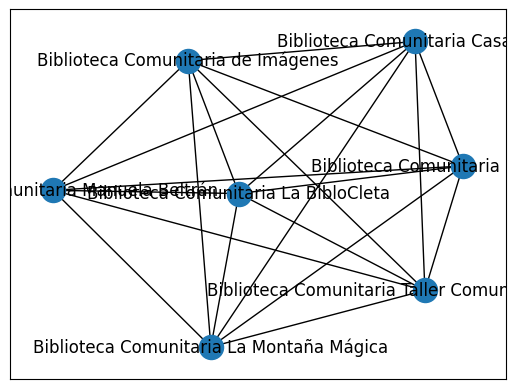

In [23]:
from sandbox.multiplex_network import LayerFactory

# Create layer factory with Gower similarity
factory = LayerFactory(
    similarity_strategy=GowerSimilarity
)

# Create network layer with optimization
network = factory.create_layer(
    master_table=df,
    nodes_name=list(df["BibliotecaNombre"].unique()),
    weighting_strategy='feature_entropy',
    threshold=None,
    nan_strategy='impute'
)
import networkx as nx
nx.draw_networkx(network, with_labels=True)

In [24]:
nx.write_graphml(network, "network.graphml")